In [12]:
import os.path
import pandas as pd
import pandas_datareader.data as web
import requests
from datetime import datetime
from datetime import timedelta
import matplotlib
import matplotlib.pyplot as plt
import pyfolio as pf


now = datetime.now()
start = datetime.strptime("01-04-2010", "%m-%d-%Y")
start_conts = start
##base_url = 'http://ws.spk.gov.tr/PortfolioValues/api/PortfoyDegerleri/'

portfolio = pd.DataFrame({'Name': [],'Number': [],'Price': []})
backtrack = pd.DataFrame(index=pd.date_range(start, now, dtype='datetime64[ns]'), columns = ['MarketValue', 'Cost', 'ReturnSeries'])
backtrack = backtrack.fillna(0)
money = int(raw_input("Starting money:"))
eur = web.DataReader('TRY=X','yahoo', start_conts, now)['Adj Close']
money = money / eur[start_conts]
monthly_money = int(raw_input("Montly investment:"))
#Stock code list and their percentages.
code_list = []
code_list_perc = []
number_of_inputs = int(raw_input("Number of stocks:"))


for i in range(0,number_of_inputs):
    #Stock name and percentages
    stock_name = str(raw_input("Name of the stock:"))
    stock_percentage = float(raw_input("Stock percentage:"))
    code_list.append(stock_name)
    code_list_perc.append(stock_percentage)
    #Getting the initial stock variables.
    ##resp = requests.get(base_url + stock_name + "/2/" + "01-02-2014/01-02-2014")
    resp = web.DataReader(stock_name, 'yahoo', start, start)['Adj Close']
    ##eur = web.DataReader('TRY=X','yahoo', start, start)['Adj Close']
    for item in resp.iteritems():
        number_of_stocks = (stock_percentage * money) / (item[1])
        s = pd.Series([stock_name, number_of_stocks, item[1]], index = ['Name', 'Number', 'Price'])
    portfolio = portfolio.append(s, ignore_index=True)


Starting money:10000
Montly investment:0
Number of stocks:1
Name of the stock:SPY
Stock percentage:1


In [13]:

portfolio['Value'] = portfolio.Number * portfolio.Price
#Determining the initial backtrack positions.
backtrack.ix[start, 'MarketValue'] = portfolio['Value'].sum()
backtrack.ix[start, 'Cost'] = portfolio['Value'].sum()
start = start + timedelta(days=1)
i = 0
for stock in code_list:
    ##start_date = datetime.strftime(start, '%m-%d-%Y')
    ##end_date = datetime.strftime(now, '%m-%d-%Y')
    ##second_base_url = base_url + stock + "/2/" + start_date + "/" + end_date
    ##response = requests.get(second_base_url, timeout=None)
    response = web.DataReader(stock, 'yahoo', start, now)['Adj Close']
    #Calculating the money for certain stock.
    money_for_stock = money * code_list_perc[i]
    stock_month = 1
    for item in response.iteritems():
        date_string = str(item[0]).split(" ")[0]
        my_date = datetime.strptime(date_string, "%Y-%m-%d")
        portfolio.ix[i,'Price'] = item[1]
        backtrack.ix[my_date, 'MarketValue'] += portfolio.ix[i,'Number'] * portfolio.ix[i,'Price']
        backtrack.ix[my_date, 'Cost'] += money_for_stock
        back_date = my_date - timedelta(days=1)

        #Doing the montly investment.
        if (my_date.month != stock_month):
            money_for_stock += monthly_money * code_list_perc[i]
            stock_month += 1
            if stock_month == 13 : stock_month = 1
            portfolio.ix[i,'Number'] += (monthly_money * code_list_perc[i]) / (item[1])
    #Increasing i for the next stocks percentage.
    i += 1

In [14]:
backtrack = backtrack[backtrack.MarketValue != 0]
backtrack = backtrack.dropna()
portfolio

,Name,Number,Price,Value
0,SPY,69.11825,238.270004,6788.405404


In [15]:
eur = web.DataReader('TRY=X','yahoo', start_conts, now)['Adj Close']
eur = eur.reindex(backtrack.index.sort_values())
eur = eur.fillna(method = 'ffill')

In [16]:
backtrack['MarketValue'] = backtrack['MarketValue'] * eur

In [17]:
back_mv = backtrack.ix[start_conts, 'MarketValue']
back_cost =  backtrack.ix[start_conts, 'Cost']
for index, item in backtrack.iterrows():
    rt = (item["MarketValue"] / (back_mv + (item["Cost"] - back_cost))) - 1
    backtrack.ix[index,'ReturnSeries'] = rt
    back_mv = item['MarketValue']
    back_cost = item['Cost']

In [18]:
backtrack
backtrack = backtrack[backtrack.ReturnSeries < 0.1]
backtrack = backtrack[backtrack.ReturnSeries > -0.1]
new = backtrack['MarketValue']
plt.plot(new)
plt.savefig('x.png')

new.to_csv('atk.csv')

In [8]:
plt.plot(backtrack['ReturnSeries'])
plt.savefig('x.png')
new = backtrack['MarketValue']
new = new.tz_localize('utc')

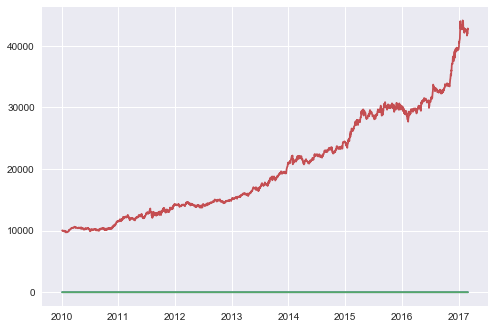

In [9]:
plt.plot(backtrack['MarketValue'])
plt.show()

Entire data start date: 2010-01-04
Entire data end date: 2017-03-02


Backtest Months: 85


Performance statistics,Backtest
annual_return,0.22
cum_returns_final,3.27
annual_volatility,0.16
sharpe_ratio,1.36
calmar_ratio,1.99
stability_of_timeseries,0.98
max_drawdown,-0.11
omega_ratio,1.26
sortino_ratio,2.08
skew,-0.01


Worst drawdown periods,net drawdown in %,peak date,valley date,recovery date,duration
0,11.29,2011-07-26,2011-08-08,2011-10-18,61
1,10.30,2015-09-16,2016-02-11,2016-05-10,170
2,7.22,2011-03-03,2011-04-18,2011-05-26,61
3,6.91,2010-03-24,2010-07-02,2010-11-24,176
4,6.56,2012-03-21,2012-06-11,2012-08-31,118




[-0.019 -0.028]


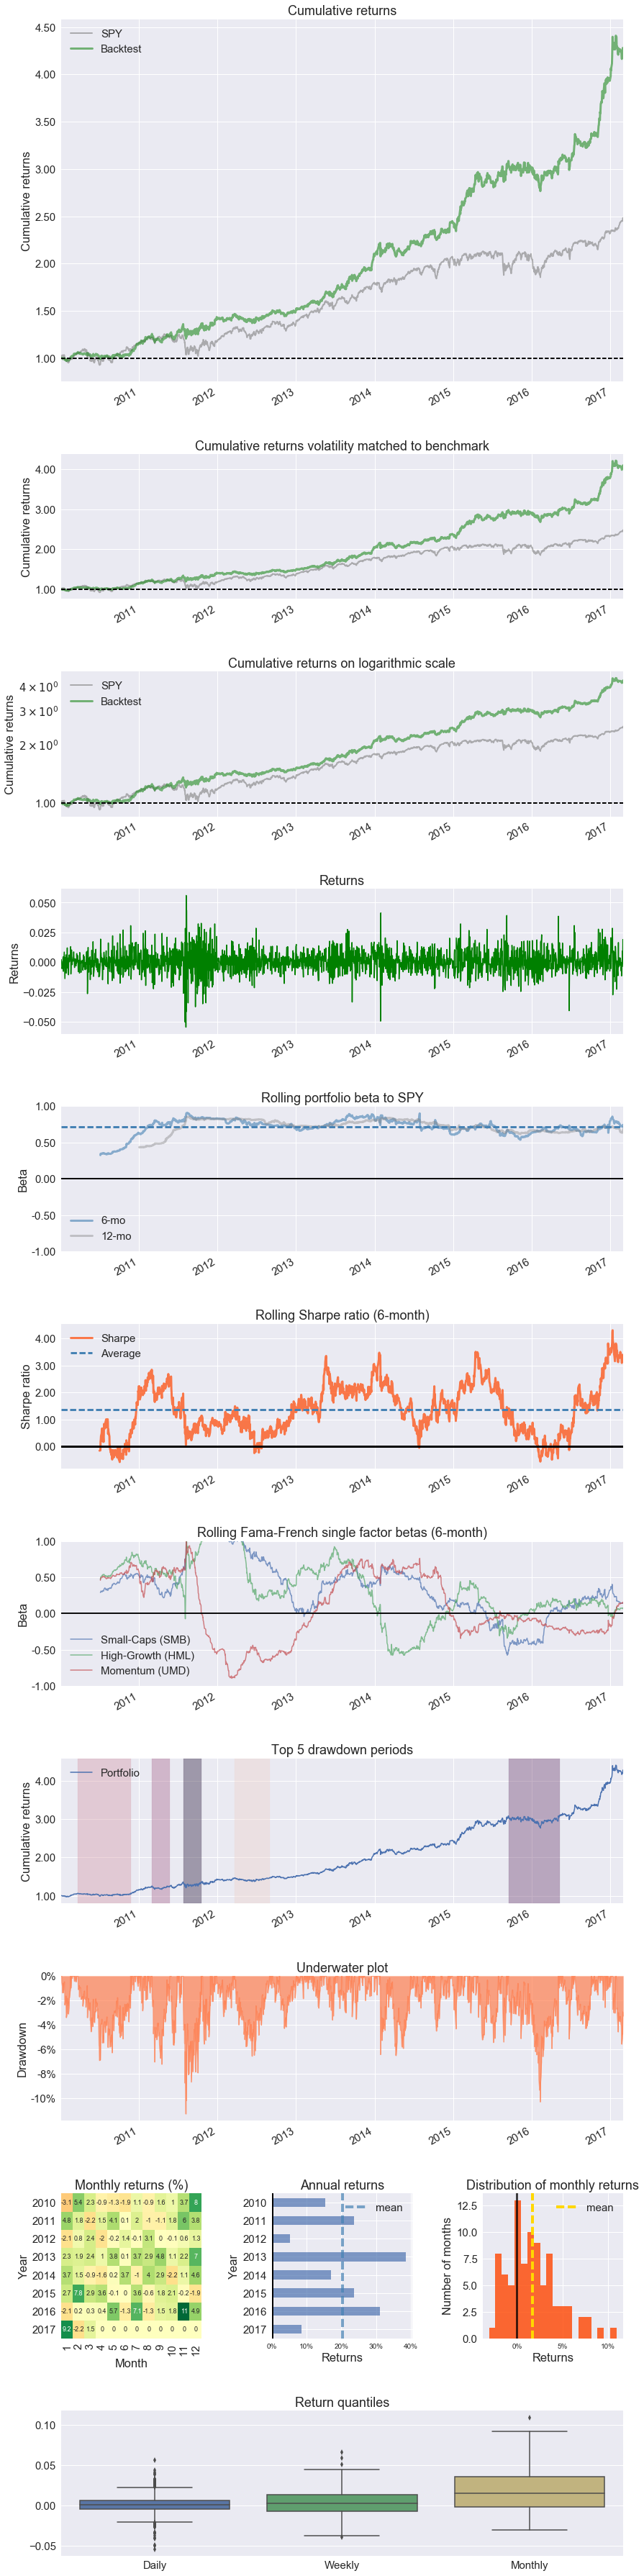

In [10]:
pf.create_returns_tear_sheet(new)

In [23]:
backtrack

,MarketValue,Cost,ReturnSeries
2010-01-04,10000.000000,6788.405404,0.000000
2010-01-05,10023.748423,6788.405404,0.002375
2010-01-06,10021.951140,6788.405404,-0.000179
2010-01-07,10064.940747,6788.405404,0.004290
2010-01-08,10005.788265,6788.405404,-0.005877
2010-01-11,9966.158282,6788.405404,-0.003961
2010-01-12,9895.678474,6788.405404,-0.007072
2010-01-13,9966.214898,6788.405404,0.007128
2010-01-14,10015.887211,6788.405404,0.004984
2010-01-15,9910.954276,6788.405404,-0.010477
